# Comparison of Neural Models on pretrained Word2Vec embeddings

## Feedforward Neural Network

Following an experiment to compare neural models, we discovered odd results showing that bag of words could outperform embeddings. This experiment attempts to tweak the embeddings to show the expected results under the assumption that the problem is not the amount of data. If the problem is the amount of data we will investigate this in another experiment.

Again, we will show Bag of Words results:

In [1]:
from scripts import training_helpers
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Embedding, MaxPooling2D, LSTM
from tensorflow.keras.regularizers import l2
from pandas import DataFrame
from seaborn import boxplot
import matplotlib.pyplot as plt
import json

import gensim
import numpy as np

read_existing_embeddings = True

Using TensorFlow backend.


In [13]:
data_frame = training_helpers.get_data_frame()
raw_features = data_frame['review']
labels = [x for x in data_frame['deceptive']]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_features)
bow_features = tokenizer.texts_to_matrix(raw_features, mode='tfidf')

In [15]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1
maxlen = max([len(x) for x in raw_features])
padded_reviews = pad_sequences(bow_features, padding='post', maxlen=maxlen)

In [ ]:
def get_ff_bow_model():
  model = Sequential([
      Dense(16, activation=relu, input_shape=(corpus_vocab_size,), kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

ff_bow_scores = run_cross_validate(get_ff_bow_model, bow_features, labels, cv=10, verbose=0)

And now we will get results for embeddings. This time I will use pretrained Word2Vec. Although this was not trained directly on words from our dataset, the Word2Vec has a higher dimensionality (making it harder to run on our machines) and so may show better results.

In [4]:
embedding_matrix = None
embedding_length = 0
if read_existing_embeddings:
  embedding_length=300
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  with open('data.json', 'r') as infile:
      data = json.load(infile)
      for i in range(len(data)):
          embedding_matrix[i] = np.array(data[i], dtype=np.float32)
else:
  word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../data/embeddings/GoogleNews-vectors-negative300.bin",
                                                                 binary=True)
  embedding_length = word_vectors.vector_size
    
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  for word, index in corpus_words.items():
    if word in word_vectors.vocab:
      embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

  with open('data.json', 'w') as outfile:
      json.dump(embedding_matrix.tolist(), outfile)

In [ ]:
def get_ff_wv_model():
  model_ff_wv = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False,
                input_length=corpus_vocab_size),
      Flatten(),
      Dense(16, activation=relu, kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model_ff_wv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_ff_wv

In [ ]:
ff_wv_scores = run_cross_validate(get_ff_wv_model, bow_features, labels, cv=5)

In [ ]:
print ("Bag of words: ", ff_bow_scores['accuracies'])
print ("Word vectors: ", ff_wv_scores['accuracies'])

ff_scores_entries =[('Bag of Words', x) for x in ff_bow_scores['accuracies']] + [('Word Vectors', x) for x in ff_wv_scores['accuracies']]
ff_scores_data_frame = DataFrame(ff_scores_entries, columns=['input type', 'accuracy'])

In [ ]:
boxplot(x='input type', y='accuracy', data=ff_scores_data_frame)
plt.show()

It looks like word vectors are doing better now! Although they should be more accurate than Bag of Words, unless this is an exceptional case. The next step here is to investigate how BoW and word vectors perform on more data, since a small amount of data is a case known to cause results like this. It is also very unlikely Bag of Words will perform as well on a large dataset.

## Convolutional Neural Network

Research has shown that word embeddings perform better than Bag of Words (Convolutional Neural Networks for Sentence Classification, Yoon Kim 2014). We will use our convolutional network on pretrained Word2Vec embeddings to see if we obtain an improved accuracy. First we will obtain results for bag of words again:

In [ ]:
batches = 1600
convolutional_data = np.array(np.split(np.array([[[y] for y in z] for z in bow_features]), batches))
convolutional_data.shape

In [ ]:
def get_conv_bow_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(1, 10),
          data_format="channels_last",
          input_shape=(1, corpus_vocab_size, 1),
          activation=relu),
      MaxPooling2D(pool_size=(1, 10)),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

conv_bow_scores = run_cross_validate(get_conv_bow_model, convolutional_data, labels, cv=10, categorical=True)

We filter out reviews with more than 300 words because a small number have an exceptionally large number of words and dramatically increase the memory requirements. These reviews are rare and are not expected to provide much value, while also preventing this experiment from being run on a normal machine, so I will filter them out

In [ ]:
reviews_words = []
conv_wv_labels = []
for i, raw_feature in enumerate(raw_features):
    word_sequence = text_to_word_sequence(raw_feature)
    if len(word_sequence) > 300:
        continue
    conv_wv_labels.append(labels[i])
    reviews_words.append(word_sequence)
max_review_len = max([len(x) for x in reviews_words])

vectorized_reviews = np.zeros((len(reviews_words), 1, max_review_len, 300))
for i, review in enumerate(reviews_words):
    for j, word in enumerate(review):
        vectorized_reviews[i][0][j] = [x for x in embedding_matrix[corpus_words[word]]]

In [ ]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_first",
          input_shape=(1, 300, 300),
          activation=relu),
      MaxPooling2D(strides=(1, 1), pool_size=(2, 1), data_format="channels_first"),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

conv_wv_scores = run_cross_validate(get_conv_wv_model, vectorized_reviews, conv_wv_labels, cv=6, categorical=True)

In [ ]:
print ("Bag of words: ", conv_bow_scores['accuracies'])
print ("Word vectors: ", conv_wv_scores['accuracies'])

conv_scores_entries =[('Bag of Words', x) for x in conv_bow_scores['accuracies']] + [('Word Vectors', x) for x in conv_wv_scores['accuracies']]
conv_scores_data_frame = DataFrame(conv_scores_entries, columns=['input type', 'accuracy'])

In [ ]:
boxplot(x='input type', y='accuracy', data=conv_scores_data_frame)
plt.show()

Again our results look better. If this continues to be consistent we know that Word2Vec has some property that is beneficial, which may be training on more data, or it may be the higher vector dimensionality.

## Recurrent Neural Network (LSTM)

The final experiment we will run to test the results of using pretrained Word2Vec embeddings will be our LSTM network. 
In the previous test we did with word embeddings, our accuracy was 50%, so simply a random guess. Following the trend above of pretrained embeddings giving us better accuracies, we will run a test and see if this can give any improvements for the LSTM network.
Because LSTM networks only use word embeddings as inputs, we will take our 50% result from using the OpSpam embeddings as our benchmark and immediately test the pretrained ones to see if we can get an improvement.

In [18]:
opt = Adam(lr=0.1)
def get_lstm_wv_model():
  model = Sequential([
        Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        LSTM(24),
        Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

lstm_wv_scores = run_cross_validate(get_lstm_wv_model, padded_reviews, labels, cv=5, verbose=1, epochs=3, batch_size=128, shuffle=True)

Fitting with:  (1280, 4159) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/3
896/896 [==============================] - 125s 140ms/step - loss: 0.7037 - acc: 0.4911 - val_loss: 0.6972 - val_acc: 0.4844
Epoch 2/3
896/896 [==============================] - 104s 117ms/step - loss: 0.6960 - acc: 0.4710 - val_loss: 0.6927 - val_acc: 0.5156
Epoch 3/3
320/320 [==============================] - 19s 60ms/step
Fitting with:  (1280, 4159) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/3
896/896 [==============================] - 106s 118ms/step - loss: 0.6954 - acc: 0.4933 - val_loss: 0.6946 - val_acc: 0.4844
Epoch 2/3
896/896 [==============================] - 103s 115ms/step - loss: 0.6933 - acc: 0.5067 - val_loss: 0.6927 - val_acc: 0.5182
Epoch 3/3
320/320 [==============================] - 20s 62ms/step
Fitting with:  (1280, 4159) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/3
896/896 [==============================] - 106s 1

In [23]:
lstm_scores_entries =[('Word Vectors', x) for x in lstm_bow_scores['accuracies']]
lstm_scores_data_frame = DataFrame(lstm_scores_entries, columns=['input type', 'accuracy'])

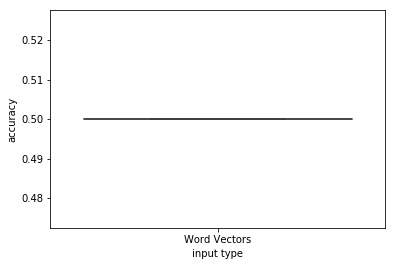

In [25]:
boxplot(x='input type', y='accuracy', data=lstm_scores_data_frame)
plt.show()

I know. Pretty inconclusive, crappy graph. 

At this stage, we now know that LSTM's are not going to work with a dataset this small. 
After trying many configurations of learning rates, batch sizes, data normalization, LSTM cells, dropout, embedding dimensions and review truncated lengths we can conclude that we're going to have to use more data to start seeing some results from LSTM's. 

They also take an extremely long time to run, so it's hard to know if we're doing the right thing by running them locally.